Importiere `pyboard` und andere Module. Wichtig ist, dass sich die Datei [`pyboard.py`](https://github.com/micropython/micropython/blob/master/tools/pyboard.py) im selben Verzeichnis wie dieses Notebook befinden. 

In [4]:
import pyboard
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

pb = None

Öffne eine serielle Verbindung zum Microcontroller-Board. Wenn hier das Board nicht gefunden wird, kann man folgendes probieren:
- USB-Kabel ab- und wieder anstecken  
- Überprüfen, ob die richtige Schnittstelle angegeben ist

In [5]:
if pb is None:
    try:
        pb = pyboard.Pyboard("COM3")
    except pyboard.PyboardError as e:
        print(e)

Öffne Zugang zum REPL

In [6]:
pb.enter_raw_repl()

Definiere eine einfache Funktion, um ein Skript auf dem Board auszuführen. Die Funktion geht davon aus, dass das Board über `pb` anzusprechen ist.

In [7]:
def run_on_board(code, wait_s=0, no_print=False):
    for ln in code:
        res = pb.exec(ln)
        if len(res) > 0 and not no_print:
            res = res[:-2].decode()
            print(res)
    if wait_s > 0:
        time.sleep(wait_s)        
    return res    

Rufe das Skript auf, dass den Wärmebildsensor AMG8833 auf dem I2C-Bus detektiert und initialisiert. Der Sensor braucht etwas Zeit, daher die kurze Wartezeit nach der Initialisierung.

In [8]:
script = [
    'from amg88xx import AMG88XX',
    'import helper.busio as busio',
    'import helper.dio as dio',
    'power5V = dio.DigitalOut(16, value=True)',
    'i2c = busio.I2CBus(400000, 22, 23)',
    'amg = AMG88XX(i2c)',
]
_ = run_on_board(script, wait_s=0.4)

Software I2C bus frequency is 400.0 kHz
Scanning I2C bus ...
... 2 device(s) found ([96, 105])
[     amg88xx] GRID-Eye IR 8x8 thermal camera      (0.1.0.0): ok


Definiert die Hilfsfunktion `get_image()`, die ein neues Bild zurückliefert.

Die Funktion ruft erst das Skript auf, dass Daten vom Wärmebildsensor liest. Die Daten werden als 1D-Vektor mit 64 Temperaturwerten (in °Celsius) geliefert. Da die `pyboard`-Funktion einen String zurückgibt, wird dieser mittels einer `json`-Funktion in eine Liste umgewandelt. Anschließend wird der Vektor in ein 8x8 Pixel-Bild umgeformt, dann rotiert und geflippt, damit es richig herum angezeigt wird.

In [9]:
def get_image():
    script = [
        'img_raw = list(amg.pixels_64x1)',
        'print(img_raw)'
    ]
    raw = json.loads(run_on_board(script, no_print=True))
    return np.flip(np.transpose(np.reshape(raw, (8, 8))))

img = get_image()
print(img)

[[21 23 25 22 20 20 20 20]
 [21 26 28 25 21 20 20 19]
 [22 27 28 26 20 20 20 20]
 [22 25 29 27 22 21 20 20]
 [22 25 27 27 26 25 21 20]
 [23 25 26 26 25 26 23 20]
 [24 25 26 26 26 25 23 21]
 [25 26 26 26 26 25 23 21]]


Das aktuelle Wärmebild im Original (links) und geglättet (rechts):

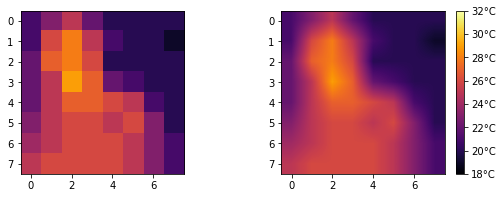

In [10]:
# Erstelle eine Abbildung mit zwei Unterfenstern
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,3))

# Stelle das Wärmebild in den jeweiligen Unterfenstern dar
im1 = ax1.imshow(img, cmap='inferno', vmin=18, vmax=32)
im2 = ax2.imshow(img, cmap='inferno', vmin=18, vmax=32, interpolation="bilinear")

# Füge eine Farbskala hinzu
plt.colorbar(im1, format="%.0f°C")

Das folgende Skript liest den Sensor `nrepeats` Mal aus, skaliert die Werte auf den Bereich von `tmin` bis `tmax` °Celsius und zeigt es kontinuierlich an (wenn `smooth == True`, dann wird das Bild geglättet. Zum Anhalten der Animation auf den blauen Knopf drücken.

In [8]:
%matplotlib notebook

# Darstellungsparameter
nrepeats = 50
interpol = "bilinear"
tmin = 20
tmax = 34
cmap = "inferno" 

# Erstelle eine Abbildung mit einem Unterfenster
fig, (ax1) = plt.subplots(1, 1, figsize=(3,3))

# Erzeuge ein leeres Bild und zeige es zusammen mit der Farbskala an
img = np.zeros((8,8))
im = plt.imshow(img, cmap=cmap, vmin=tmin, vmax=tmax, interpolation=interpol)
plt.colorbar(format="%.0f°C")

# Die folgende Funktion lädt ein Bild vom Sensor und kopiert es in die Abbildung
def update1(i):
    img = get_image()
    im.set_array(img)
    return im, 

# Zeige die Abbildung als Animation
ani1 = FuncAnimation(plt.gcf(), update1, frames=range(nrepeats), interval=1, blit=True)
plt.show()

<IPython.core.display.Javascript object>

In [11]:
_ = run_on_board(['import blob as blob'])

Definiert eine Hilfsfunktion, die ein Wärmebild liest und mit Hilfe der Funktion `find_blobs`, die auf dem Board läuft, "Blobs" im Bild detektiert. 

In [99]:
def get_image_blobs():
    script = [
        'img_raw = list(amg.pixels_64x1)',
        'print(img_raw)'
    ]
    raw = json.loads(run_on_board(script, no_print=True))
    img = np.flip(np.transpose(np.reshape(raw, (8, 8))))
    script = [
        'blob_list = blob.find_blobs_timed(img_raw, (8, 8))',
        'print(blob_list)'
    ]
    blobs = json.loads(run_on_board(script, no_print=True))
    return img, blobs

Liest ein Bild und die dazughörigen Blobs ein. In `blob.py` kann man auch auf die Masken zugreifen, die zeigen, welche Pixel über dem Temperaturschwellenwert lagen (`msk1`) und welche Pixel zu welchem Blob gehören (`msk2`).

In [100]:
img, blobs = get_image_blobs()   
msk1 = json.loads(run_on_board(["print(list(blob.pMskSave1))"], no_print=True).decode())
msk1 = np.flip(np.transpose(np.reshape(msk1, (8, 8))))
msk2 = json.loads(run_on_board(["print(list(blob.pMskSave2))"], no_print=True).decode())
msk2 = np.flip(np.transpose(np.reshape(msk2, (8, 8))))

Erstelle eine Abbildung mit dem Wärmebild ("heatmap") und den beiden Masken (siehe oben)

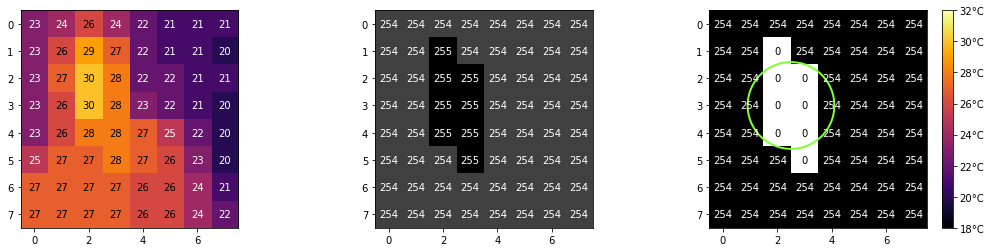

In [103]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))
im1 = ax1.imshow(img, cmap='inferno', vmin=18, vmax=32)
im2 = ax2.imshow(msk1, cmap='Greys', vmin=250, vmax=255)
im3 = ax3.imshow(msk2, cmap='Greys', vmin=0, vmax=2)

circs = []
cs = [(0.5, 1, 0.2), (1, 0.5, 0.2), (0.2, 0.5, 1)]
for i, b in enumerate(blobs):
    r = np.sqrt(b[0]/np.pi)
    c = (1,1,1) if i >= len(cs) else cs[i]
    circs.append(Circle((8-b[3]-1, 8-b[4]-1), radius=r, fill=False, ec=c, lw=2))
    ax3.add_patch(circs[i])
    
for i in range(8):
    for j in range(8):
        c = "w" if img[i, j] < 26 else "black"
        text = ax1.text(j, i, img[i, j], ha="center", va="center", color=c)
for i in range(8):
    for j in range(8):
        text = ax2.text(j, i, msk1[i, j], ha="center", va="center", color="w")
for i in range(8):
    for j in range(8):
        c = "w" if msk2[i, j] > 200 else "black"
        text = ax3.text(j, i, msk2[i, j], ha="center", va="center", color=c)

plt.colorbar(im1, format="%.0f°C")